# Option pricing with MC & deep learning model

## Data 0700.HK

Duration: 2016-2017

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import math
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

def gauss_func(x, mu, sigma):
    return ((1 / (np.sqrt(2 * np.pi) * sigma)) * \
        np.exp(-0.5 * (1 / sigma * (x - mu))**2))

fn_dir = 'data_options'
fn_prefix = '0700_HK'
fn = os.path.join(fn_dir, fn_prefix+'.csv')

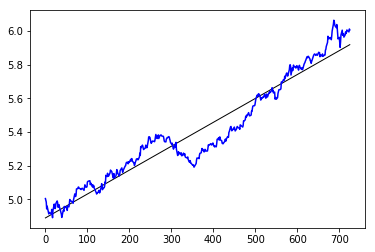

In [3]:
stk = pd.read_csv(fn, parse_dates=['Date'],)
log_price = np.log(stk.Close.values)

date_min = stk.Date.min()
date_s = (stk.Date - date_min) / np.timedelta64(1,'D')
date = date_s.values.reshape(-1,1)

regr = linear_model.LinearRegression(copy_X=True)
regr.fit(date, log_price)

logP_pred = regr.predict(date)

_ = plt.plot(date, logP_pred, color='k', lw=1)
_ = plt.plot(date, log_price, color='b')

(mean, std) = (0.203%, 1.530%)


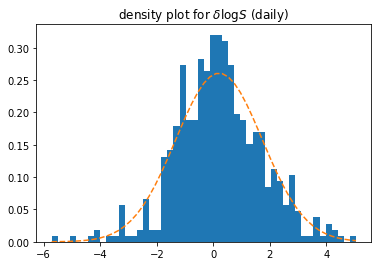

In [28]:
d_logP = np.diff(np.log(stk.Close.values))*100 # percentage
mu = np.mean(d_logP)
sigma = np.std(d_logP)

n, bins, patches = plt.hist(d_logP, 50, density=True)
y = gauss_func(bins, mu, sigma)
_ = plt.plot(bins, y, '--')
plt.title(r'density plot for $\delta\log S$ (daily)')
print('(mean, std) = ({:1.3f}%, {:1.3f}%)'.format(mu, sigma))

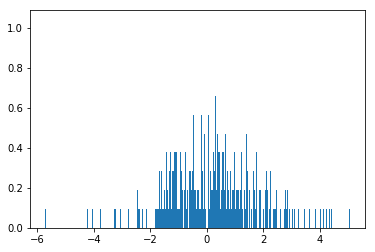

In [9]:
_ = plt.hist(d_logP, 500, density=True)
# save as above, to be compared with the learned distribution shown below

## Generate samples from the learned distribution of $\log S$

Using invertible neural net (invNN), the distribution of $\log S$ is learned. The following is the sampled distribution from the invNN:

In [2]:
import pathlib, os
import matplotlib.pyplot as plt
import option_MC_invNN as invNN

in_dim = 2
inv_mode = 1
# inv_mode : 0:Shuffle, 1:InvDense, 2:InvDense_LU

fn_weights = os.path.join(fn_dir, 'opt.invD.weights')
fn_w = fn_weights if pathlib.Path(fn_weights).is_file() else None

invModel = invNN.InvNN_options(in_dim, inv_mode=inv_mode, fn_weights=fn_w)

Using TensorFlow backend.


In [3]:
# training
train_data, val_data = invNN.gen_data(fn, [2,1])
invModel.train(train_data, val_data, fn_weights=fn_weights)

Train on 986 samples, validate on 493 samples
Epoch 1/30
986/986 [==============================] - 10s 10ms/step - loss: 37.6039 - val_loss: 0.4982

Epoch 00001: val_loss improved from inf to 0.49817, saving model to opt.invD.weights
Epoch 2/30
986/986 [==============================] - 1s 694us/step - loss: -1.3568 - val_loss: -1.7455

Epoch 00002: val_loss improved from 0.49817 to -1.74548, saving model to opt.invD.weights
Epoch 3/30
986/986 [==============================] - 1s 700us/step - loss: -1.7743 - val_loss: -1.8947

Epoch 00003: val_loss improved from -1.74548 to -1.89467, saving model to opt.invD.weights
Epoch 4/30
986/986 [==============================] - 1s 688us/step - loss: -2.0741 - val_loss: -2.3839

Epoch 00004: val_loss improved from -1.89467 to -2.38394, saving model to opt.invD.weights
Epoch 5/30
986/986 [==============================] - 1s 690us/step - loss: -2.4242 - val_loss: -2.6540

Epoch 00005: val_loss improved from -2.38394 to -2.65402, saving model to

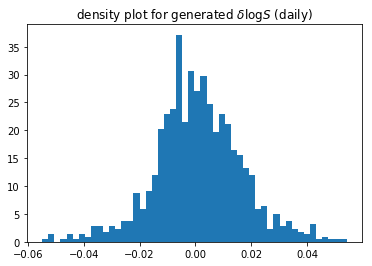

In [4]:
gen_size = 1000

dlogS_gen = invModel.rand(gen_size)

plt.title(r'density plot for generated $\delta\log S$ (daily)')
n, bins, patches = plt.hist(dlogS_gen, 50, density=True)

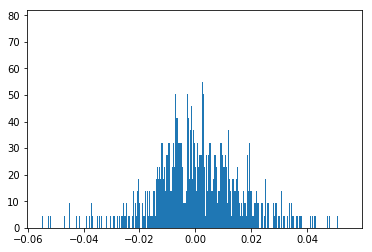

In [5]:
_ = plt.hist(dlogS_gen, 500, density=True)
# note: the generated samples may not exist in the original data,
# showing that the invNN truly learned the distribution

## MC for call option pricing

We first use Monte Carlo to generate the paths from the learned distribution. Left panel is the paths, and the right for the price distribution at maturity $T$ (which is skewed compared with the fitted Gaussian (orange dash line).

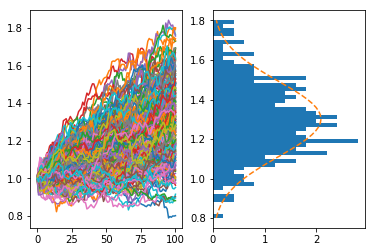

In [7]:
T_days = 100
T_days_p1 = T_days+1
annual_days = 252
T = T_days/annual_days

plt.subplot(1,2,1)

path_size = 250
S_T = np.empty(path_size, dtype=float)
for i in range(path_size):
    path = np.cumsum(invModel.rand(T_days_p1))/100
    # /100 converts % to number, same below
    path[0] = 0
    date = np.arange(T_days_p1)
    S_path = np.exp(path)
    S_T[i] = S_path[-1]
    _ = plt.plot(date, S_path, )

plt.subplot(1,2,2)
mu = np.mean(S_T)
sigma = np.std(S_T)
_, bins, _ = plt.hist(S_T, 50, density=True, orientation='horizontal')
y = gauss_func(bins, mu, sigma)
_ = plt.plot(y, bins, '--')

In [27]:
def euro_vanilla_call_MC(S, K, T, T_days, r, entRatio=1, numPath=1000):
    assert isinstance(T_days, int)

    randDaily = (invModel.rand(numPath*T_days)/100).reshape([numPath, -1]).sum(axis=1)
    # /100 meaning: see above
    S_T = S*np.exp(randDaily)
    sum_S = np.maximum(S_T-K, 0.0).sum()
    call = math.exp(-r*T)*sum_S/numPath
    return call/entRatio

## a helper function to deal with parameter conversion
def var_xfm(K, T_dt, r_pct, entRatio, 
        T_begin=pd.to_datetime(datetime.now().date())):
    T_days = (T_dt - T_begin) / np.timedelta64(1, 'D')
    T_yrs = T_days / 252
    r = r_pct / 100
    
    return [K, T_yrs, int(T_days), r, entRatio]

S = 315.6
K = 330.2
T_dt = pd.to_datetime('2019-03-25') # 15527
r_pct = 1.82571
entRatio = 100

print('MC pricing with daily summation')
param = var_xfm(K, T_dt, r_pct, entRatio)
print('call price: ', end='')
for _ in range(8):
    call = euro_vanilla_call_MC(S, *param, numPath=500)
    print('{:1.4f}, '.format(call), end='')
print()

MC pricing with daily summation
call price: 0.5664, 0.5734, 0.5645, 0.5533, 0.5779, 0.5752, 0.5677, 0.5371, 
